In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv
/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv
/kaggle/input/child-mind-institute-problematic-internet-use/train.csv
/kaggle/input/child-mind-institute-problematic-internet-use/test.csv
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=00115b9f/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=001f3379/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0745c390/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=eaab7a96/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=8ec2cc63/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=b2987a65/part-0.parquet
/kaggle/input/child-mind-institute-problematic-intern

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from sklearn.metrics import cohen_kappa_score
import lightgbm as lgb

import warnings
warnings.simplefilter("ignore")

In [3]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

In [4]:
train.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print("Tập dữ liệu Train có:", train.shape[0], " hàng ", "và ", train.shape[1], " cột.")

Tập dữ liệu Train có: 3960  hàng  và  82  cột.


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [7]:
test.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print("Tập dữ liệu Test có:", test.shape[0], " hàng ", "và ", test.shape[1], " cột.")

Tập dữ liệu Test có: 20  hàng  và  59  cột.


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


In [10]:
train_columns = set(train.columns)
test_columns = set(test.columns)

common_columns = train_columns & test_columns
print(f"Các cột chung ({len(common_columns)}):", sorted(common_columns))

train_only_columns = train_columns - test_columns
print(f"Các cột chỉ có trong tập dữ liệu Train ({len(train_only_columns)}):", sorted(train_only_columns))

test_only_columns = test_columns - train_columns
if test_only_columns:
    print(f"Các cột chỉ có trong tập dữ liệu Test ({len(test_only_columns)}):", sorted(test_only_columns))
else:
    print("Không có cột nào chỉ xuất hiện trong tập dữ liệu Test")

Các cột chung (59): ['BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'BIA-Season', 'Basic_Demos-Age', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'CGAS-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'FGC-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Season', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'PAQ_A-PAQ_A_Total', 'PAQ_A-Season', 'PAQ_C-PAQ_C_Total', 'PAQ_C-Season', 'Physical-BMI', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Height', 'Physical-Season', 'Physical-Systolic_BP', 'Physical-Waist_Circumferenc

In [11]:
missing_common = {col: {
    'mis_count': train[col].isnull().sum(),
    'mis_percentage': train[col].isnull().sum() / train.shape[0] * 100
} 
                  for col in common_columns}

print("Tóm tắt các giá trị bị thiếu trong cột:")
for col, missing in sorted(missing_common.items(), key=lambda x: x[1]['mis_count'], reverse=True):
    print(f"Cột: {col:<40} | Số giá trị thiếu: {missing['mis_count']} | Tỉ lệ phần trăm thiếu: {missing['mis_percentage']:.2f}%")

Tóm tắt các giá trị bị thiếu trong cột:
Cột: PAQ_A-Season                             | Số giá trị thiếu: 3485 | Tỉ lệ phần trăm thiếu: 88.01%
Cột: PAQ_A-PAQ_A_Total                        | Số giá trị thiếu: 3485 | Tỉ lệ phần trăm thiếu: 88.01%
Cột: Fitness_Endurance-Time_Mins              | Số giá trị thiếu: 3220 | Tỉ lệ phần trăm thiếu: 81.31%
Cột: Fitness_Endurance-Time_Sec               | Số giá trị thiếu: 3220 | Tỉ lệ phần trăm thiếu: 81.31%
Cột: Fitness_Endurance-Max_Stage              | Số giá trị thiếu: 3217 | Tỉ lệ phần trăm thiếu: 81.24%
Cột: Physical-Waist_Circumference             | Số giá trị thiếu: 3062 | Tỉ lệ phần trăm thiếu: 77.32%
Cột: FGC-FGC_GSND_Zone                        | Số giá trị thiếu: 2898 | Tỉ lệ phần trăm thiếu: 73.18%
Cột: FGC-FGC_GSD_Zone                         | Số giá trị thiếu: 2897 | Tỉ lệ phần trăm thiếu: 73.16%
Cột: FGC-FGC_GSD                              | Số giá trị thiếu: 2886 | Tỉ lệ phần trăm thiếu: 72.88%
Cột: FGC-FGC_GSND                

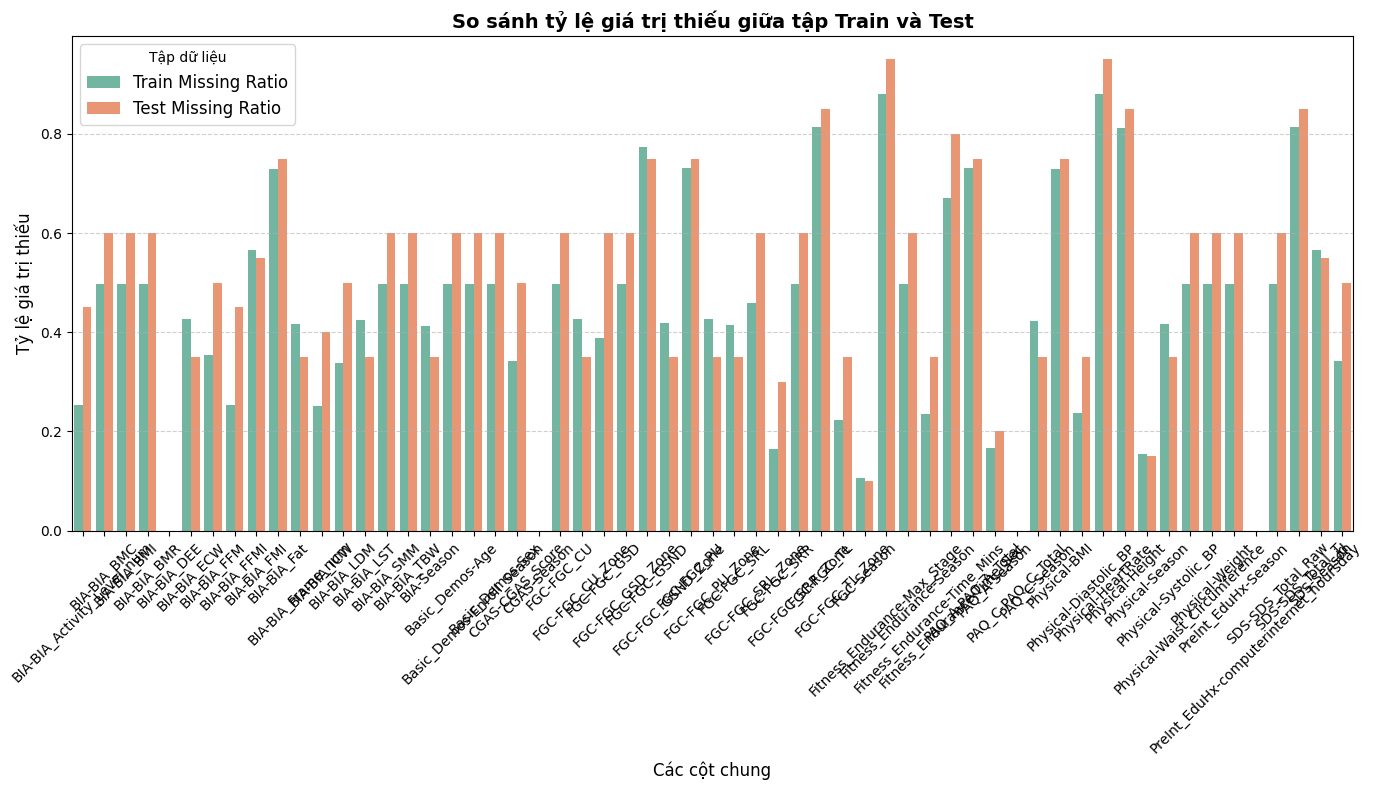

In [12]:
import seaborn as sns

missing_train = {col: train[col].isnull().sum() for col in common_columns}
missing_test = {col: test[col].isnull().sum() for col in common_columns}

total_train = len(train)
total_test = len(test)

missing_train_ratio = {col: missing_train[col] / total_train for col in common_columns}
missing_test_ratio = {col: missing_test[col] / total_test for col in common_columns}

missing_df = pd.DataFrame({
    'Column': sorted(common_columns),  
    'Train Missing Ratio': list(missing_train_ratio.values()),  
    'Test Missing Ratio': list(missing_test_ratio.values())  
}).melt(id_vars='Column', var_name='Dataset', value_name='Missing Ratio')

plt.figure(figsize=(14, 8))
sns.barplot(data=missing_df, x='Column', y='Missing Ratio', hue='Dataset', palette='Set2')

plt.xticks(rotation=45, fontsize=10)  
plt.xlabel('Các cột chung', fontsize=12)  
plt.ylabel('Tỷ lệ giá trị thiếu', fontsize=12) 
plt.title('So sánh tỷ lệ giá trị thiếu giữa tập Train và Test', fontsize=14, fontweight='bold')  
plt.legend(title='Tập dữ liệu', fontsize=12)  
plt.grid(axis='y', linestyle='--', alpha=0.6)  

plt.tight_layout()
plt.show()

In [13]:
missing_train_only = {col: train[col].isnull().sum() for col in train_only_columns}
missing_percentage = {col: (train[col].isnull().sum() / len(train)) * 100 for col in train_only_columns}

print("\nTóm tắt số lượng giá trị thiếu trong các cột chỉ có trong bộ dữ liệu huấn luyện:")
for col, missing in sorted(missing_train_only.items(), key=lambda x: x[1], reverse=True):
    print(f"Cột: {col:<25} | Số lượng giá trị thiếu: {missing} | Tỉ lệ thiếu: {missing_percentage[col]:.2f}%")


Tóm tắt số lượng giá trị thiếu trong các cột chỉ có trong bộ dữ liệu huấn luyện:
Cột: PCIAT-PCIAT_17            | Số lượng giá trị thiếu: 1235 | Tỉ lệ thiếu: 31.19%
Cột: PCIAT-PCIAT_18            | Số lượng giá trị thiếu: 1232 | Tỉ lệ thiếu: 31.11%
Cột: PCIAT-PCIAT_16            | Số lượng giá trị thiếu: 1232 | Tỉ lệ thiếu: 31.11%
Cột: PCIAT-PCIAT_05            | Số lượng giá trị thiếu: 1231 | Tỉ lệ thiếu: 31.09%
Cột: PCIAT-PCIAT_13            | Số lượng giá trị thiếu: 1231 | Tỉ lệ thiếu: 31.09%
Cột: PCIAT-PCIAT_07            | Số lượng giá trị thiếu: 1231 | Tỉ lệ thiếu: 31.09%
Cột: PCIAT-PCIAT_15            | Số lượng giá trị thiếu: 1230 | Tỉ lệ thiếu: 31.06%
Cột: PCIAT-PCIAT_08            | Số lượng giá trị thiếu: 1230 | Tỉ lệ thiếu: 31.06%
Cột: PCIAT-PCIAT_09            | Số lượng giá trị thiếu: 1230 | Tỉ lệ thiếu: 31.06%
Cột: PCIAT-PCIAT_19            | Số lượng giá trị thiếu: 1230 | Tỉ lệ thiếu: 31.06%
Cột: PCIAT-PCIAT_03            | Số lượng giá trị thiếu: 1229 | Tỉ lệ thiếu: 3

In [14]:
non_numeric_columns = train.select_dtypes(exclude=['number']).columns

print("Các cột không phải kiểu số trong bộ dữ liệu huấn luyện:")
for i, col in enumerate(non_numeric_columns, 1):
    print(f"{i:>2}. {col}")

Các cột không phải kiểu số trong bộ dữ liệu huấn luyện:
 1. id
 2. Basic_Demos-Enroll_Season
 3. CGAS-Season
 4. Physical-Season
 5. Fitness_Endurance-Season
 6. FGC-Season
 7. BIA-Season
 8. PAQ_A-Season
 9. PAQ_C-Season
10. PCIAT-Season
11. SDS-Season
12. PreInt_EduHx-Season


In [15]:
def process_data(data, is_train=True):
    common_columns = [
        'id', 'PreInt_EduHx-Season', 'FGC-FGC_SRL_Zone', 'BIA-BIA_FFMI',
        'Fitness_Endurance-Time_Sec', 'Fitness_Endurance-Time_Mins',
        'BIA-BIA_ECW', 'FGC-FGC_SRR', 'BIA-Season',
        'PAQ_C-PAQ_C_Total', 'FGC-FGC_TL_Zone', 'Physical-HeartRate',
        'BIA-BIA_Fat', 'Fitness_Endurance-Max_Stage', 'Basic_Demos-Enroll_Season',
        'PreInt_EduHx-computerinternet_hoursday', 'FGC-FGC_PU', 'BIA-BIA_TBW',
        'BIA-BIA_BMR', 'BIA-BIA_BMC', 'Physical-Diastolic_BP',
        'Physical-Weight', 'FGC-FGC_GSND_Zone', 'Physical-Systolic_BP',
        'BIA-BIA_Activity_Level_num', 'PAQ_A-Season', 'SDS-SDS_Total_Raw',
        'Physical-BMI', 'Basic_Demos-Sex', 'SDS-SDS_Total_T', 'FGC-FGC_GSD',
        'FGC-FGC_CU', 'PAQ_A-PAQ_A_Total', 'FGC-FGC_GSD_Zone',
        'Fitness_Endurance-Season', 'FGC-FGC_GSND', 'FGC-FGC_PU_Zone',
        'BIA-BIA_ICW', 'FGC-Season', 'FGC-FGC_SRL', 'Physical-Waist_Circumference',
        'BIA-BIA_Frame_num', 'FGC-FGC_SRR_Zone', 'Physical-Height',
        'Physical-Season', 'BIA-BIA_FMI', 'PAQ_C-Season', 'FGC-FGC_CU_Zone',
        'BIA-BIA_SMM', 'CGAS-Season', 'SDS-Season', 'BIA-BIA_BMI',
        'FGC-FGC_TL', 'BIA-BIA_LST', 'Basic_Demos-Age', 'BIA-BIA_LDM',
        'BIA-BIA_DEE', 'CGAS-CGAS_Score', 'BIA-BIA_FFM'
    ]

    if is_train:
        common_columns.append('PCIAT-PCIAT_Total')  

    data = data[common_columns]

    label_encoders = {}
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le  

    if is_train:
        missing_threshold = 0.5
        missing_ratios = data.isnull().mean()
        columns_to_drop = missing_ratios[missing_ratios > missing_threshold].index
        data.drop(columns=columns_to_drop, inplace=True)

        data.dropna(inplace=True)
    else:
        for col in data.columns:
            if data[col].isnull().any():
                if data[col].dtype in ['float64', 'int64']:
                    data[col].fillna(data[col].mean(), inplace=True)
                else:
                    data[col].fillna(data[col].mode()[0], inplace=True)

    return data

In [16]:
processed_train = process_data(train, is_train=True)
processed_test = process_data(test, is_train=False)

In [17]:
target_column = "PCIAT-PCIAT_Total"  

target = processed_train[target_column]  
features = processed_train.drop(columns=[target_column])  

print("Kích thước các đặc trưng trong tập dữ liệu Train:", features.shape)
print("Kích thước cột mục tiêu trong tập dữ liệu Train:", target.shape)

Kích thước các đặc trưng trong tập dữ liệu Train: (1130, 49)
Kích thước cột mục tiêu trong tập dữ liệu Train: (1130,)


In [18]:
print("Các cột trong bộ dữ liệu Train đã xử lý:", processed_train.columns.tolist())
print("Các cột trong bộ dữ liệu Test đã xử lý:", processed_test.columns.tolist())

Các cột trong bộ dữ liệu Train đã xử lý: ['id', 'PreInt_EduHx-Season', 'FGC-FGC_SRL_Zone', 'BIA-BIA_FFMI', 'BIA-BIA_ECW', 'FGC-FGC_SRR', 'BIA-Season', 'FGC-FGC_TL_Zone', 'Physical-HeartRate', 'BIA-BIA_Fat', 'Basic_Demos-Enroll_Season', 'PreInt_EduHx-computerinternet_hoursday', 'FGC-FGC_PU', 'BIA-BIA_TBW', 'BIA-BIA_BMR', 'BIA-BIA_BMC', 'Physical-Diastolic_BP', 'Physical-Weight', 'Physical-Systolic_BP', 'BIA-BIA_Activity_Level_num', 'PAQ_A-Season', 'SDS-SDS_Total_Raw', 'Physical-BMI', 'Basic_Demos-Sex', 'SDS-SDS_Total_T', 'FGC-FGC_CU', 'Fitness_Endurance-Season', 'FGC-FGC_PU_Zone', 'BIA-BIA_ICW', 'FGC-Season', 'FGC-FGC_SRL', 'BIA-BIA_Frame_num', 'FGC-FGC_SRR_Zone', 'Physical-Height', 'Physical-Season', 'BIA-BIA_FMI', 'PAQ_C-Season', 'FGC-FGC_CU_Zone', 'BIA-BIA_SMM', 'CGAS-Season', 'SDS-Season', 'BIA-BIA_BMI', 'FGC-FGC_TL', 'BIA-BIA_LST', 'Basic_Demos-Age', 'BIA-BIA_LDM', 'BIA-BIA_DEE', 'CGAS-CGAS_Score', 'BIA-BIA_FFM', 'PCIAT-PCIAT_Total']
Các cột trong bộ dữ liệu Test đã xử lý: ['id', '

In [19]:
common_columns = [col for col in common_columns if col in processed_train.columns and col in processed_test.columns]

processed_train_data = processed_train[common_columns]
processed_test_data = processed_test[common_columns]

In [20]:
print("Kích thước bộ dữ liệu Train đã xử lý:", processed_train_data.shape)
print("Kích thước bộ dữ liệu Test đã xử lý:", processed_test_data.shape)

Kích thước bộ dữ liệu Train đã xử lý: (1130, 49)
Kích thước bộ dữ liệu Test đã xử lý: (20, 49)


In [21]:
X_train = processed_train_data.drop(columns=["id"])
X_test = processed_test_data.drop(columns=["id"])

In [22]:
import numpy as np
from sklearn.metrics import cohen_kappa_score

def convert(scores, scale_factor=1.3, bin_edges=None):
    if bin_edges is None:
        bin_edges = [30, 50, 80]  
    scores = np.array(scores) * scale_factor
    bins = np.digitize(scores, bins=bin_edges, right=False)  
    return bins

def quadratic_weighted_kappa(y_true, y_pred, bin_edges=None):
    y_true_cat = convert(y_true, bin_edges=bin_edges)
    y_pred_cat = convert(y_pred, bin_edges=bin_edges)
    return cohen_kappa_score(y_true_cat, y_pred_cat, weights='quadratic')

y_true = [20, 35, 55, 85, 40]
y_pred = [25, 38, 50, 80, 43]

kappa = quadratic_weighted_kappa(y_true, y_pred)
print(f"Quadratic Weighted Kappa: {kappa:.4f}")

Quadratic Weighted Kappa: 0.8780


In [23]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

def train_folds_qwk(model_class, X, y, test_data, n_splits=5, params=None, bin_edges=None):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(y))
    test_preds = np.zeros((len(test_data), n_splits))
    val_kappas = []

    for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(X, y), total=n_splits, desc="Training Folds")):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model = model_class(**params) if params else model_class()

        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)
        oof_preds[val_idx] = y_val_pred
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred, bin_edges=bin_edges)
        val_kappas.append(val_kappa)
        print(f"Fold {fold + 1} - Validation QWK: {val_kappa:.4f}")

        test_preds[:, fold] = model.predict(test_data)

    test_preds_mean = test_preds.mean(axis=1)
    print(f"Giá trị trung bình của chỉ số QWK trên các tập kiểm tra (folds): {np.mean(val_kappas):.4f}")
    return test_preds_mean

In [24]:
import lightgbm as lgb

def train_lgbm_with_qwk(X, y, test_data, params, n_splits=5, bin_edges=None):
    return train_folds_qwk(lgb.LGBMRegressor, X, y, test_data, n_splits=n_splits, params=params, bin_edges=bin_edges)

params = {
    'learning_rate': 0.03,
    'n_estimators': 500,
    'num_leaves': 80,
    'max_depth': 5,
    'min_child_samples': 50,
    'subsample': 0.8,
    'colsample_bytree': 0.5,
    'reg_alpha': 3,
    'reg_lambda': 0.01,
    'random_state': 42
}

In [25]:
from sklearn.metrics import mean_squared_error, r2_score

def train_folds_regressor(model_class, X, y, test_data, n_splits=5, params=None):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(y))
    test_preds = np.zeros((len(test_data), n_splits))
    val_rmse, val_r2 = [], []

    for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(X, y), total=n_splits, desc="Training Folds")):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model = model_class(**params) if params else model_class()

        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)
        oof_preds[val_idx] = y_val_pred

        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        r2 = r2_score(y_val, y_val_pred)
        val_rmse.append(rmse)
        val_r2.append(r2)
        print(f"Fold {fold + 1} - Validation RMSE (độ lệch trung bình gốc): {rmse:.4f}, R²: {r2:.4f}")

        test_preds[:, fold] = model.predict(test_data)

    test_preds_mean = test_preds.mean(axis=1)
    print(f"Giá trị trung bình của RMSE trong quá trình kiểm tra (validation): {np.mean(val_rmse):.4f}, Giá trị trung bình của R^2 trong quá trình kiểm tra (validation): {np.mean(val_r2):.4f}")
    return test_preds_mean

In [26]:
pred = train_folds_regressor(lgb.LGBMRegressor, X_train, target, X_test, n_splits=5, params=params)
print("Dự đoán trung bình cho dữ liệu kiểm tra:", pred)

Training Folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4728
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 48
[LightGBM] [Info] Start training from score 27.002212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

Training Folds:  20%|██        | 1/5 [00:00<00:02,  1.40it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Folds:  40%|████      | 2/5 [00:00<00:01,  2.25it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Folds:  60%|██████    | 3/5 [00:01<00:00,  2.80it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.13it/s]

Fold 4 - Validation RMSE (độ lệch trung bình gốc): 16.1706, R²: 0.3093
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4720
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 48
[LightGBM] [Info] Start training from score 27.196903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [27]:
pred

array([26.259135  , 11.28061977, 27.21020221, 22.84844834, 28.57147974,
       34.46684828, 26.58197038, 23.18778822, 30.14580515, 29.0103419 ,
       24.86400074, 21.42939884, 34.89830878, 32.37776459, 30.50409654,
       20.1613333 ,  9.43427754, 20.61264936, 31.64100959, 25.98453147])

In [28]:
test_ids = test["id"]
test_ids

0     00008ff9
1     000fd460
2     00105258
3     00115b9f
4     0016bb22
5     001f3379
6     0038ba98
7     0068a485
8     0069fbed
9     0083e397
10    0087dd65
11    00abe655
12    00ae59c9
13    00af6387
14    00bd4359
15    00c0cd71
16    00d56d4b
17    00d9913d
18    00e6167c
19    00ebc35d
Name: id, dtype: object

In [29]:
submission = pd.DataFrame({'id': test_ids.values,'sii': convert(pred)})

submission.to_csv('submission.csv',index=False)

In [30]:
submission

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,1
7,0068a485,1
8,0069fbed,1
9,0083e397,1
